### Machine Learning: Summer 2020
### Project 1

# Predicting whether a dog will be adopted within a week from the Austin Animal Shelter

### Anshul Dabas and Anndi Russell

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt2

## Experiment Objective

Our experiment will attempt to create a model that will predict whether a dog will be adopoted within 1 week of it arrival at the Austin Animal Shelter in Austin, TX. We are interested in animal welfare and we know anecdotally that certain characteristics (such as a particular breed or color) of an animal result in a higher likelihood of adoption. We are interested in finding out which characteristics are the best predictors for a speedy adoption at this particular shelter.

This information would be useful to a shelter for many reasons. For example, if this shelter has success placing dogs with certain characteristics, it could raise the adoption fees of those dogs to help cover the shelter costs, knowing that a popular type of dog will perhaps have more people interested in it despite the higher fee. This research could also be duplicated at other shelters, and the differences in popular dog characteristics in different regions could be examined; if the Austin Animal Shelter has a high probability of placing pit bulls in homes, but a shelter in Dallas does not have that same level of success, a transfer program could be arranged in order to facilitate the best chance of a dog finding a new home. There are numerous other applications for this research so we feel that it is relevant and exciting project.

We chose the Austin Animal Shelter as the source for our data for a couple of reasons. First, this is the largest no-kill shelter in the country, so the set of data is large. Second, this data is available via public API through Austin's Open Data Portal. As quoted from the website: "We encourage the use of public data that the City of Austin has published to spark innovation, promote public collaboration, increase government transparency, and inform decision making" (citation: https://data.austintexas.gov/). Ethically, this dataset does not pose any issues since it is explicity made publically available and it does not contain any sensitive personal information that could lead to any type of discrimation or bias.

Dataset description: Our data came in two datasets, one for intakes and one for outcomes (such as adoption) for each animal's shelter stay. Both datasets had descriptive information of the animal (animal type, intake condition, color, breed, sex, intake type/outcome type, age, name) as well as a time stamp for its intake or outcome.

## Data Collection

The data was downloaded in csv format archived on the website on July 21, 2020. The data on this site is updated daily, so it is current to the day of download. The data of interest for us is provided separately in an "intake" file and an "outcome" file. We downloaded both, and read into dataframes:

In [2]:
df_intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv')
df_outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [3]:
df_intakes.head(2)

Animal ID    Name                DateTime               MonthYear  \
0   A786884  *Brock  01/03/2019 04:19:00 PM  01/03/2019 04:19:00 PM   
1   A706918   Belle  07/05/2015 12:59:00 PM  07/05/2015 12:59:00 PM   

                        Found Location Intake Type Intake Condition  \
0  2501 Magin Meadow Dr in Austin (TX)       Stray           Normal   
1     9409 Bluegrass Dr in Austin (TX)       Stray           Normal   

  Animal Type Sex upon Intake Age upon Intake                     Breed  \
0         Dog   Neutered Male         2 years                Beagle Mix   
1         Dog   Spayed Female         8 years  English Springer Spaniel   

         Color  
0     Tricolor  
1  White/Liver

In [4]:
df_outcomes.head(2)

Animal ID   Name                DateTime               MonthYear  \
0   A794011  Chunk  05/08/2019 06:20:00 PM  05/08/2019 06:20:00 PM   
1   A776359  Gizmo  07/18/2018 04:02:00 PM  07/18/2018 04:02:00 PM   

  Date of Birth Outcome Type Outcome Subtype Animal Type Sex upon Outcome  \
0    05/02/2017    Rto-Adopt             NaN         Cat    Neutered Male   
1    07/12/2017     Adoption             NaN         Dog    Neutered Male   

  Age upon Outcome                    Breed              Color  
0          2 years   Domestic Shorthair Mix  Brown Tabby/White  
1           1 year  Chihuahua Shorthair Mix        White/Brown

In our data preprocessing we will reduce this to one dataframe with 6 feature and 1 outcome. The outcome will be binary with class labels 1 and 0.

## Data Preprocessing

In [5]:
print(df_intakes.shape)
print(df_outcomes.shape)

(118918, 12)
(119009, 12)


We have approximately 119000 rows of data in each table. We could not find documentation as to why the outcomes have a slightly greater number of rows than the intakes. 

The 'Outcome Type' tells us in what manner the animal left the shelter. Check if all animals in outcomes have an 'Outcome Type' listed:

In [6]:
df_outcomes['Outcome Type'].isnull().sum()

6

Drop these 6 rows, since this is the most important data for our analysis and we have plenty of data to work with. No need to impute.

In [7]:
df_outcomes.dropna(subset=['Outcome Type'], inplace=True)
df_outcomes['Outcome Type'].isnull().sum()

0

In [8]:
print(df_intakes.shape)
print(df_outcomes.shape)

(118918, 12)
(119003, 12)


DateTime and MonthYear columns are duplicates:

In [9]:
print(df_intakes['DateTime'].equals(df_intakes['MonthYear']))
print(df_outcomes['DateTime'].equals(df_outcomes['MonthYear']))

True
True


Drop unnecessary columns in outcomes and intakes:

In [10]:
df_outcomes = df_outcomes.drop(['Name', 'MonthYear', 'Date of Birth', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color'], axis=1)
df_intakes = df_intakes.drop(['Name', 'MonthYear', 'Found Location'], axis=1)

The dataframes have some animals that have multiple intakes and outcomes. We are going to drop these from our analysis, or it will impact our merge (merge my default will create all combinations of pairs). The parameter keep='first' would allow us to keep the first entry of each animal ID, but since the data is not necessarily in chronological order we cannot be sure that the first intake and the first outcome for a particular animal will be from the same shelter stay event. For this reason, it is better that we drop the duplicates altogether. Though we are losing some information, we still are left with 106000 rows which is appropriate for our analysis (this is the benefit of starting with a large dataset).

In [11]:
df_intakes = df_intakes.drop_duplicates(subset='Animal ID')
df_outcomes = df_outcomes.drop_duplicates(subset='Animal ID')

In [12]:
print(df_intakes.shape)
print(df_outcomes.shape)

(106280, 9)
(106383, 4)


Merge together. Only include animals that have an outcome listed. We're not concerned with animals still in the shelter, as we cannot be sure they will be adopted at all. They may be bound for a transfer or euthanasia, in which case they do not fit into our question of interest. This translates to an inner join; only animals recorded in both tables will be included.

In [13]:
df_merged=pd.merge(df_intakes,df_outcomes,on='Animal ID',how='inner')

In [14]:
df_merged.head(2)

Animal ID              DateTime_x Intake Type Intake Condition Animal Type  \
0   A786884  01/03/2019 04:19:00 PM       Stray           Normal         Dog   
1   A706918  07/05/2015 12:59:00 PM       Stray           Normal         Dog   

  Sex upon Intake Age upon Intake                     Breed        Color  \
0   Neutered Male         2 years                Beagle Mix     Tricolor   
1   Spayed Female         8 years  English Springer Spaniel  White/Liver   

               DateTime_y     Outcome Type Outcome Subtype  
0  01/08/2019 03:11:00 PM         Transfer         Partner  
1  07/05/2015 03:13:00 PM  Return to Owner             NaN

In [15]:
df_merged.shape

(105569, 12)

In [16]:
df_merged = df_merged.drop(['Animal ID'], axis=1)

In [17]:
df_merged.isnull().sum()

DateTime_x              0
Intake Type             0
Intake Condition        0
Animal Type             0
Sex upon Intake         1
Age upon Intake         0
Breed                   0
Color                   0
DateTime_y              0
Outcome Type            0
Outcome Subtype     54165
dtype: int64

Drop the 1 row without a sex upon intake (large enough dataset that dropping a row is fine):

In [18]:
df_merged = df_merged.dropna(subset=['Sex upon Intake'])

In [19]:
df_merged.isnull().sum()

DateTime_x              0
Intake Type             0
Intake Condition        0
Animal Type             0
Sex upon Intake         0
Age upon Intake         0
Breed                   0
Color                   0
DateTime_y              0
Outcome Type            0
Outcome Subtype     54164
dtype: int64

Change DateTime columns to pandas datetime object:

In [20]:
df_merged['DateTime_x']=pd.to_datetime(df_merged['DateTime_x'])

In [21]:
df_merged['DateTime_y']=pd.to_datetime(df_merged['DateTime_y'])

In [22]:
df_merged.dtypes

DateTime_x          datetime64[ns]
Intake Type                 object
Intake Condition            object
Animal Type                 object
Sex upon Intake             object
Age upon Intake             object
Breed                       object
Color                       object
DateTime_y          datetime64[ns]
Outcome Type                object
Outcome Subtype             object
dtype: object

In [23]:
df_merged.head(2)

DateTime_x Intake Type Intake Condition Animal Type  \
0 2019-01-03 16:19:00       Stray           Normal         Dog   
1 2015-07-05 12:59:00       Stray           Normal         Dog   

  Sex upon Intake Age upon Intake                     Breed        Color  \
0   Neutered Male         2 years                Beagle Mix     Tricolor   
1   Spayed Female         8 years  English Springer Spaniel  White/Liver   

           DateTime_y     Outcome Type Outcome Subtype  
0 2019-01-08 15:11:00         Transfer         Partner  
1 2015-07-05 15:13:00  Return to Owner             NaN

Calculate the duration of time that an animal was at the shelter:

In [24]:
df_merged['TimeDuration']=(df_merged['DateTime_y']-df_merged['DateTime_x'])

In [25]:
df_merged.head(2)

DateTime_x Intake Type Intake Condition Animal Type  \
0 2019-01-03 16:19:00       Stray           Normal         Dog   
1 2015-07-05 12:59:00       Stray           Normal         Dog   

  Sex upon Intake Age upon Intake                     Breed        Color  \
0   Neutered Male         2 years                Beagle Mix     Tricolor   
1   Spayed Female         8 years  English Springer Spaniel  White/Liver   

           DateTime_y     Outcome Type Outcome Subtype    TimeDuration  
0 2019-01-08 15:11:00         Transfer         Partner 4 days 22:52:00  
1 2015-07-05 15:13:00  Return to Owner             NaN 0 days 02:14:00

Drop original DateTime columns:

In [26]:
df_merged=df_merged.drop(['DateTime_x'], axis=1)
df_merged=df_merged.drop(['DateTime_y'], axis=1)

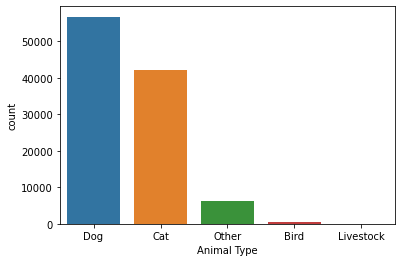

In [27]:
sns.countplot(x="Animal Type", data=df_merged)

Subset our data to include only dogs. Originally we considered looking at all types of animals, but we decided that limiting it to just dogs would reduce dimensionality and focus our research:

In [28]:
df_dogs=df_merged[df_merged['Animal Type']=='Dog']
df_dogs['Animal Type'].unique()

array(['Dog'], dtype=object)

In [29]:
df_dogs=df_dogs.drop(['Animal Type'], axis=1)

We are left with over 56000 rows:

In [30]:
df_dogs.shape

(56705, 9)

Here we can see the different outcomes for the dogs in this dataset:

In [31]:
df_dogs['Outcome Type'].unique()

array(['Transfer', 'Return to Owner', 'Adoption', 'Died', 'Euthanasia',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

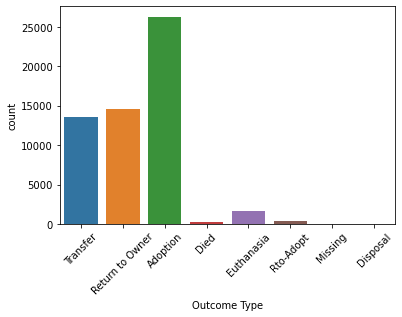

In [32]:
chart=sns.countplot(x="Outcome Type", data=df_dogs)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

We are only concerned with animals that had a successful outcome: Adoption, Return to Owner, or Rto-Adopt. We could not find a specific definition for "rto-adopt" on the data website, but we are assuming it indicates that the pet was returned to its owner through an adoption process, so we include it here.

In [33]:
df_dogs=df_dogs[df_dogs['Outcome Type'].isin([ 'Return to Owner', 'Adoption', 'Rto-Adopt'])]
df_dogs['Outcome Type'].unique()

array(['Return to Owner', 'Adoption', 'Rto-Adopt'], dtype=object)

In [34]:
df_dogs=df_dogs.drop(['Outcome Type'], axis=1)

The outcome subtype column does not add value to our exploration, since we are considering 'Return to Owner', 'Adoption', 'Rto-Adopt' as successful regardless of the subtype. Drop this column:

In [35]:
df_dogs['Outcome Subtype'].unique()

array([nan, 'Foster', 'Offsite', 'Field', 'At Vet', 'Customer S', 'Prc'],
      dtype=object)

In [36]:
df_dogs=df_dogs.drop(['Outcome Subtype'], axis=1)

In [37]:
df_dogs.head(2)

Intake Type Intake Condition Sex upon Intake Age upon Intake  \
1       Stray           Normal   Spayed Female         8 years   
2       Stray           Normal     Intact Male       11 months   

                      Breed        Color    TimeDuration  
1  English Springer Spaniel  White/Liver 0 days 02:14:00  
2               Basenji Mix  Sable/White 6 days 22:34:00

In [38]:
df_dogs.shape

(41293, 7)

This leaves us with over 41000 rows. TimeDuration will be our outcome (we change this to binary in a future step). 

We have 5 categorical predictor features: Intake Type, Intake Condition, Sex upon Intake, Breed, and Color. 

We have 1 numeric features: Age upon Intake (this will be reported in days after processing). 

First, we explore how many unique values are in each of the categorical columns.

In [39]:
print('Intake Type:',df_dogs['Intake Type'].nunique())
print('Intake Condition:',df_dogs['Intake Condition'].nunique())
print('Sex upon Intake:',df_dogs['Sex upon Intake'].nunique())
print('Breed:',df_dogs['Breed'].nunique())
print('Color:',df_dogs['Color'].nunique())

Intake Type: 5
Intake Condition: 10
Sex upon Intake: 5
Breed: 1991
Color: 337


We can see above that we have large numbers of values in both Breed and Color. These will need to be simplified in order to reduce dimensionality of the dataset.

We start by exploring the variety of breeds and their counts:

In [40]:
df_merged['Breed'].unique()

array(['Beagle Mix', 'English Springer Spaniel', 'Basenji Mix', ...,
       'Carolina Dog/American Pit Bull Terrier',
       'Collie Rough/Spanish Water Dog', 'Rhod Ridgeback/Redbone Hound'],
      dtype=object)

In [41]:
df_merged['Breed'].value_counts()

Domestic Shorthair Mix               29048
Pit Bull Mix                          6329
Labrador Retriever Mix                5577
Chihuahua Shorthair Mix               5516
Domestic Shorthair                    5336
                                     ...  
Rhod Ridgeback/Mastiff                   1
Rottweiler/Chinese Sharpei               1
Rex-Mini/Lop-English                     1
Basset Hound/Pembroke Welsh Corgi        1
Rhod Ridgeback/Plott Hound               1
Name: Breed, Length: 2569, dtype: int64

First, we remove the word "Mix" from any breed name. ex: 'beagle' and 'beagle mix' will be the same breed for our analysis. We assume that "beagle mix" looks mostly like a beagle, and thus will be considered simply as a beagle for someone looking to adopt.

Without more detailed infomormation from the shelter, we cannot simplify further. For example, we don't know whether a "Beagle/Dachshund Longhair" looks and acts more like a beagle or a dachsund. We do not want to just drop part of this; it would be an inappropriate over-simplification. However, if the shelter's process was to report the most prominent breed first, it could be worth only including the first one listed; since we don't have that information, we keep all parts of the description.

In [42]:
df_dogs['Breed']=df_dogs['Breed'].str.replace(' Mix', '')
print('Breed:',df_dogs['Breed'].nunique())

Breed: 1830


Removing 'mix' reduced the number of unique values from 1991 to 1830.

We now will examine just a subset of the 30 most common breeds in our dataset of adopted or returned-to-owner dogs:

In [43]:
list(df_dogs['Breed'].value_counts().nlargest(n=30).index)

['Pit Bull',
 'Labrador Retriever',
 'Chihuahua Shorthair',
 'German Shepherd',
 'Australian Cattle Dog',
 'Dachshund',
 'Siberian Husky',
 'Border Collie',
 'Boxer',
 'Miniature Poodle',
 'Australian Shepherd',
 'Yorkshire Terrier',
 'Catahoula',
 'Rat Terrier',
 'Miniature Schnauzer',
 'Staffordshire',
 'Jack Russell Terrier',
 'Cairn Terrier',
 'Beagle',
 'Great Pyrenees',
 'Chihuahua Longhair',
 'Rottweiler',
 'Pointer',
 'American Bulldog',
 'Anatol Shepherd',
 'Shih Tzu',
 'Black Mouth Cur',
 'Plott Hound',
 'Chihuahua Shorthair/Dachshund',
 'American Pit Bull Terrier']

We see a large variety of breeds in this subset, and this will reduce the dimensionality of our data to a manageable size for one-hot-encoding. We considered including more than 30 or less then 30, but after exploration we concluded that 30 gives a good variety of breeds while still remaining a manageable size for future processing.

We subset our dataframe to only include these breeds, and display the remaining number of rows:

In [44]:
df_dogs=df_dogs[df_dogs['Breed'].isin(list(df_dogs['Breed'].value_counts().nlargest(n=30).index))]

In [45]:
print(df_dogs['Breed'].nunique())
print(df_dogs.shape)

30
(28390, 7)


This leaves us with over 28000 rows for analysis. Now we will do a similar exploration with 'color'. Start with viewing the most common 30 colors to get an idea of the information:

In [46]:
list(df_dogs['Color'].value_counts().nlargest(n=30).index)

['Black/White',
 'Brown/White',
 'Black',
 'Tan/White',
 'White',
 'Tan',
 'Black/Tan',
 'Brown',
 'Tricolor',
 'Black/Brown',
 'White/Black',
 'Blue/White',
 'White/Brown',
 'Brown Brindle/White',
 'Brown/Black',
 'White/Tan',
 'Red/White',
 'Red',
 'Tan/Black',
 'Brown Brindle',
 'Chocolate/White',
 'Yellow',
 'Cream',
 'Fawn/White',
 'Chocolate',
 'Sable',
 'White/Brown Brindle',
 'Brown/Tan',
 'Black/Tricolor',
 'Buff']

We can see in this set that the same colors can be listed in different orders (black/white and white/black). We would need more information from the shelter about how the record these colors to get the most accurate representation of this. For our purposes, we're going to assume black/white and white/black mean the same thing. Here, we perform a mapping to result in consisent orders. We could just reduce the number of values to the top 30, but we think we'll have a more accurate representation if we do this mapping first.

In [47]:
df_dogs['Color'].nunique()

288

In [48]:
colorlist=list(df_dogs['Color'])
len(colorlist)

28390

The following code block will build a new color column that doesn't have duplicate color pairs. Ex: White/Black will become Black/White if the latter is already in the new column. The printout of the length confirms that we didn't accidentally skip any additions.

In [49]:
final_colors=[]

for color in colorlist:
    if '/' in color: #two colors listed
        splt=color.split('/')
        switchcolor=splt[1]+'/'+splt[0] #reverse order of colors
        if splt[1]==splt[0]: #Black/Black becomes Black
            final_colors.append(splt[1])
        elif switchcolor in final_colors: #if the reverse order already exists, append it
            final_colors.append(switchcolor)
        else: #if the reverse order does not exist, append the orginal
            final_colors.append(color)
    else: #only one color listed
        final_colors.append(color)
        
len(final_colors)

28390

Reassign this new list to our colors column:

In [50]:
df_dogs['Color']=final_colors

A quick scan of the 50 most common shows that we don't have any repeating color pairs now like we did in the top 30 before this fix:

In [51]:
list(df_dogs['Color'].value_counts().nlargest(n=30).index)

['Black/White',
 'Brown/White',
 'White/Tan',
 'Brown/Black',
 'Black',
 'Black/Tan',
 'White',
 'Tan',
 'Brown',
 'Blue/White',
 'Tricolor',
 'White/Brown Brindle',
 'Red/White',
 'Chocolate/White',
 'Red',
 'Brown Brindle',
 'Yellow',
 'Gray/White',
 'Fawn/White',
 'Cream',
 'Brown/Tan',
 'Chocolate',
 'Sable',
 'Black/Tricolor',
 'Buff',
 'Blue',
 'Black/Gray',
 'Tricolor/White',
 'Blue Merle',
 'White/Cream']

In [52]:
df_dogs['Color'].nunique()

196

We reduced the number of unique colors from 288 to 196. Now we will subset our dataframe to only include animals in the top 30 most common color categories.

In [53]:
df_dogs=df_dogs[df_dogs['Color'].isin(list(df_dogs['Color'].value_counts().nlargest(n=30).index))]

In [54]:
df_dogs.shape

(25964, 7)

We still have 25000 rows to work with. This is a more accurate representation of the top color pairings than it would have been without accounting for the equivalent pairings.

In [55]:
df_dogs.head(2)

Intake Type Intake Condition Sex upon Intake Age upon Intake  \
5  Owner Surrender           Normal   Neutered Male         2 years   
7    Public Assist           Normal     Intact Male         2 years   

                Breed        Color    TimeDuration  
5  Labrador Retriever    Chocolate 3 days 04:58:00  
7  Labrador Retriever  Black/White 5 days 03:40:00

Now we need to change our TimeDuration column into a binary outcome for classification. Our question explores the probability of an animal being adopted within 1 week. A time duration of less than 1 week will be mapped to "1", everything else to "0". We chose 1 week because it was a good middle value in our dataset and provided a good mix of success and failure, as well as having practical meaning.

In [56]:
t=datetime.timedelta(days=7)
df_dogs['Success']=df_dogs['TimeDuration']<t #gives boolean outcome

tf_mapping = {True: 1, False : 0} #map booleans to 1/0
df_dogs['Success'] = df_dogs['Success'].map(tf_mapping)
df_dogs=df_dogs.drop(['TimeDuration'], axis=1)

In [57]:
df_dogs.head(2)

Intake Type Intake Condition Sex upon Intake Age upon Intake  \
5  Owner Surrender           Normal   Neutered Male         2 years   
7    Public Assist           Normal     Intact Male         2 years   

                Breed        Color  Success  
5  Labrador Retriever    Chocolate        1  
7  Labrador Retriever  Black/White        1

In [58]:
df_dogs['Success'].value_counts()

1    15352
0    10612
Name: Success, dtype: int64

We have a good mix of 1 and 0 in our outcome column. Now we move the outcome column to the beginning for simplicity and clarity:

In [59]:
movecol = df_dogs.pop('Success')
df_dogs.insert(0, movecol.name, movecol)
df_dogs.head(2)

Success      Intake Type Intake Condition Sex upon Intake Age upon Intake  \
5        1  Owner Surrender           Normal   Neutered Male         2 years   
7        1    Public Assist           Normal     Intact Male         2 years   

                Breed        Color  
5  Labrador Retriever    Chocolate  
7  Labrador Retriever  Black/White

In [60]:
df_dogs.shape

(25964, 7)

We now have our categorical columns in good shape. Now we need to change the age column to be in appropriate numeric format:

In [61]:
df_dogs['Age upon Intake'].unique()

array(['2 years', '5 months', '1 month', '3 years', '7 years', '1 year',
       '12 years', '6 months', '2 months', '14 years', '4 years',
       '8 years', '4 months', '5 years', '6 years', '3 months',
       '10 years', '7 months', '3 weeks', '9 years', '10 months',
       '11 years', '15 years', '13 years', '4 weeks', '3 days',
       '11 months', '8 months', '17 years', '0 years', '2 weeks',
       '19 years', '18 years', '9 months', '1 week', '5 weeks',
       '16 years', '1 weeks', '4 days', '1 day', '2 days', '5 days',
       '6 days'], dtype=object)

In [62]:
df_dogs['Age upon Intake'].isnull().sum()

0

Function below will turn any age into days. It will turn any negative age (as seen above) into None; this will be dropped later.

In [63]:
def yearstomonths(age):
    if age[0]=='-':
        age=None
    
    elif 'years' in age:
        age=age.replace(' years', '')
        age=int(age)
        age=age*365
    elif 'year' in age:
        age=age.replace(' year', '')
        age=int(age)
        age=age*365
        
    elif 'months' in age:
        age=age.replace(' months', '')
        age=float(age)
        age=age*30
    elif 'month' in age:
        age=age.replace(' month', '')
        age=float(age)
        age=age*30
        
    elif 'weeks' in age:
        age=age.replace(' weeks', '')
        age=int(age)
        age=age*7
    elif 'week' in age:
        age=age.replace(' week', '')
        age=int(age)
        age=age*7
    
    elif 'days' in age:
        age=age.replace(' days', '')
        age=int(age)

    elif 'day' in age:
        age=age.replace(' day', '')
        age=int(age)
        
    return age
        

In [64]:
df_dogs['Age upon Intake']=df_dogs['Age upon Intake'].map(yearstomonths)

In [65]:
df_dogs['Age upon Intake'].unique()

array([7.300e+02, 1.500e+02, 3.000e+01, 1.095e+03, 2.555e+03, 3.650e+02,
       4.380e+03, 1.800e+02, 6.000e+01, 5.110e+03, 1.460e+03, 2.920e+03,
       1.200e+02, 1.825e+03, 2.190e+03, 9.000e+01, 3.650e+03, 2.100e+02,
       2.100e+01, 3.285e+03, 3.000e+02, 4.015e+03, 5.475e+03, 4.745e+03,
       2.800e+01, 3.000e+00, 3.300e+02, 2.400e+02, 6.205e+03, 0.000e+00,
       1.400e+01, 6.935e+03, 6.570e+03, 2.700e+02, 7.000e+00, 3.500e+01,
       5.840e+03, 4.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 6.000e+00])

Here we display values for the columns Intake Type, Intake Condition, and Sex upon Intake:

In [66]:
print('Intake type:',df_dogs['Intake Type'].unique())
print()
print('Intake condition:',df_dogs['Intake Condition'].unique())
print()
print('Sex upon Intake:',df_dogs['Sex upon Intake'].unique())

Intake type: ['Owner Surrender' 'Public Assist' 'Stray' 'Euthanasia Request'
 'Abandoned']

Intake condition: ['Normal' 'Sick' 'Injured' 'Aged' 'Nursing' 'Other' 'Pregnant' 'Medical'
 'Behavior' 'Feral']

Sex upon Intake: ['Neutered Male' 'Intact Male' 'Intact Female' 'Spayed Female' 'Unknown']


These values are all appropriate for our analaysis and we think will provide valuable information to our model.

One more check of number of categories in categorical columns:

In [67]:
print('Intake Type:',df_dogs['Intake Type'].nunique())
print('Intake Condition:',df_dogs['Intake Condition'].nunique())
print('Sex upon Intake:',df_dogs['Sex upon Intake'].nunique())
print('Breed:',df_dogs['Breed'].nunique())
print('Color:',df_dogs['Color'].nunique())

Intake Type: 5
Intake Condition: 10
Sex upon Intake: 5
Breed: 30
Color: 30


This is an approriate number of features for our dataset (5 categorical and 1 numeric). As a reminder of our objective, the 'Success' column indicates whether a dog was adopted within 1 week.

Final dataset before encoding displayed below:

In [68]:
df_final=df_dogs
df_final.head(2)

Success      Intake Type Intake Condition Sex upon Intake  Age upon Intake  \
5        1  Owner Surrender           Normal   Neutered Male            730.0   
7        1    Public Assist           Normal     Intact Male            730.0   

                Breed        Color  
5  Labrador Retriever    Chocolate  
7  Labrador Retriever  Black/White

In [69]:
df_final.shape

(25964, 7)

Feature encoding via One-hot-encoding on categorical columns. Drop_first=True to prevent colinearity:

In [70]:
df_final=pd.get_dummies(df_final, drop_first=True)

In [71]:
df_final.shape

(25964, 77)

In [72]:
df_final.head()

Success  Age upon Intake  Intake Type_Euthanasia Request  \
5         1            730.0                               0   
7         1            730.0                               0   
10        1            730.0                               0   
11        0            150.0                               0   
12        0            730.0                               0   

    Intake Type_Owner Surrender  Intake Type_Public Assist  Intake Type_Stray  \
5                             1                          0                  0   
7                             0                          1                  0   
10                            0                          0                  1   
11                            0                          0                  1   
12                            0                          0                  1   

    Intake Condition_Behavior  Intake Condition_Feral  \
5                           0                       0   
7                           0                       0   
10                          0                       0   
11                          0                       0   
12                          0                       0   

    Intake Condition_Injured  Intake Condition_Medical  ...  Color_Red/White  \
5                          0                         0  ...                0   
7                          0                         0  ...                0   
10                         0                         0  ...                0   
11                         0                         0  ...                0   
12                         0                         0  ...                0   

    Color_Sable  Color_Tan  Color_Tricolor  Color_Tricolor/White  Color_White  \
5             0          0               0                     0            0   
7             0          0               0                     0            0   
10            0          0               0                     0            0   
11            0          0               0                     0            0   
12            0          0               1                     0            0   

    Color_White/Brown Brindle  Color_White/Cream  Color_White/Tan  \
5                           0                  0                0   
7                           0                  0                0   
10                          0                  0                1   
11                          0                  0                0   
12                          0                  0                0   

    Color_Yellow  
5              0  
7              0  
10             0  
11             0  
12             0  

[5 rows x 77 columns]

Split data in X features and y outcome, and then split into training and testing data. We're not scaling at this step since Random Forest doesn't require scaled columns and feature selection with Random Forest is our next step.

In [73]:
X, y = df_final.iloc[:, 1:].values, df_final.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y) 

Feature selection using Random Forest:

 1) Age upon Intake                0.424646
 2) Sex upon Intake_Intact Male    0.028729
 3) Sex upon Intake_Neutered Male  0.023287
 4) Breed_Pit Bull                 0.022766
 5) Sex upon Intake_Spayed Female  0.020176
 6) Color_Brown/White              0.018380
 7) Color_Black/White              0.018071
 8) Color_White/Tan                0.017311
 9) Intake Type_Stray              0.015812
10) Intake Type_Public Assist      0.014530
11) Intake Condition_Normal        0.014228
12) Breed_Labrador Retriever       0.014145
13) Color_Brown/Black              0.013200
14) Breed_Chihuahua Shorthair      0.012665
15) Color_Tan                      0.012373
16) Color_Brown                    0.012243
17) Color_White                    0.012180
18) Color_Black/Tan                0.011721
19) Intake Type_Owner Surrender    0.010899
20) Color_Tricolor                 0.010584
21) Breed_German Shepherd          0.010352
22) Color_White/Brown Brindle      0.009825
23) Breed_Australian Cattle Dog 

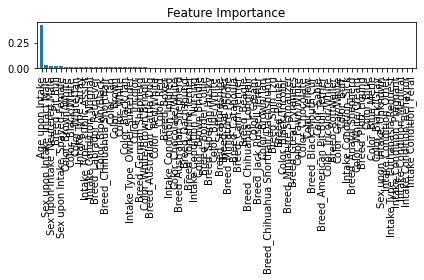

In [74]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_final.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt2.title('Feature Importance')
plt2.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt2.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt2.xlim([-1, X_train.shape[1]])
plt2.tight_layout()

Here we select the 20 most common features. In the discussion below we address why we chose 20 features:

In [75]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.010583, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 20


Printout of the selected features:

In [76]:
featlist=[]
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
    featlist.append(feat_labels[indices[f]])

 1) Age upon Intake                0.424646
 2) Sex upon Intake_Intact Male    0.028729
 3) Sex upon Intake_Neutered Male  0.023287
 4) Breed_Pit Bull                 0.022766
 5) Sex upon Intake_Spayed Female  0.020176
 6) Color_Brown/White              0.018380
 7) Color_Black/White              0.018071
 8) Color_White/Tan                0.017311
 9) Intake Type_Stray              0.015812
10) Intake Type_Public Assist      0.014530
11) Intake Condition_Normal        0.014228
12) Breed_Labrador Retriever       0.014145
13) Color_Brown/Black              0.013200
14) Breed_Chihuahua Shorthair      0.012665
15) Color_Tan                      0.012373
16) Color_Brown                    0.012243
17) Color_White                    0.012180
18) Color_Black/Tan                0.011721
19) Intake Type_Owner Surrender    0.010899
20) Color_Tricolor                 0.010584


In [77]:
featlist.insert(0, 'Success')
featlist

['Success',
 'Age upon Intake',
 'Sex upon Intake_Intact Male',
 'Sex upon Intake_Neutered Male',
 'Breed_Pit Bull',
 'Sex upon Intake_Spayed Female',
 'Color_Brown/White',
 'Color_Black/White',
 'Color_White/Tan',
 'Intake Type_Stray',
 'Intake Type_Public Assist',
 'Intake Condition_Normal',
 'Breed_Labrador Retriever',
 'Color_Brown/Black',
 'Breed_Chihuahua Shorthair',
 'Color_Tan',
 'Color_Brown',
 'Color_White',
 'Color_Black/Tan',
 'Intake Type_Owner Surrender',
 'Color_Tricolor']

Subset the dataframe to only include those features:

In [78]:
df_final=df_final[featlist]

In [79]:
df_final.shape

(25964, 21)

In [80]:
df_final.head(2)

Success  Age upon Intake  Sex upon Intake_Intact Male  \
5        1            730.0                            0   
7        1            730.0                            1   

   Sex upon Intake_Neutered Male  Breed_Pit Bull  \
5                              1               0   
7                              0               0   

   Sex upon Intake_Spayed Female  Color_Brown/White  Color_Black/White  \
5                              0                  0                  0   
7                              0                  0                  1   

   Color_White/Tan  Intake Type_Stray  ...  Intake Condition_Normal  \
5                0                  0  ...                        1   
7                0                  0  ...                        1   

   Breed_Labrador Retriever  Color_Brown/Black  Breed_Chihuahua Shorthair  \
5                         1                  0                          0   
7                         1                  0                          0   

   Color_Tan  Color_Brown  Color_White  Color_Black/Tan  \
5          0            0            0                0   
7          0            0            0                0   

   Intake Type_Owner Surrender  Color_Tricolor  
5                            1               0  
7                            0               0  

[2 rows x 21 columns]

Train/test split on this smaller dataset, and scale the numeric column 'Age upon Intake' via standard scaler:

In [81]:
X, y = df_final.iloc[:, 1:].values, df_final.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y) 

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
stdsc = StandardScaler()
#mms = MinMaxScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

At this point we are ready to implement our chosen models.

## Model Comparison

Logistic Regression:

In [83]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

lrscore = lr.score(X_test_std, y_test)
lrscore

0.6397946084724005

Decision Tree:

In [84]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

treescore = tree_model.score(X_test, y_test)
treescore

0.6437740693196405

K-Nearest Neighbors:

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

knnscore = knn.score(X_test_std, y_test)
knnscore

0.6096277278562259

In [86]:
print('Logistic Regression Accuracy:',lrscore)
print('Decision Tree Accuracy:',treescore)
print('K-Nearest Neighbors Accuracy',knnscore)

Logistic Regression Accuracy: 0.6397946084724005
Decision Tree Accuracy: 0.6437740693196405
K-Nearest Neighbors Accuracy 0.6096277278562259


Proportion of success in the test set:

In [87]:
print(y_test.sum())
print(len(y_test))
(y_test.sum()/len(y_test))

4606
7790


0.5912708600770218

#### Results summary and comments:

As seen above, the accuracy for each algorithm when the top 20 features were used was as follows:
<br>Logistic Regression Accuracy: 0.6397946084724005
<br>Decision Tree Accuracy: 0.6437740693196405
<br>K-Nearest Neighbors Accuracy 0.6096277278562259

Our proportion of successes in the test set was 0.59; each of these algorithms performed slightly better than if they had just guessed "1" every time, but not by much. We would expect accuracy of 0.5 if the algorithm was no better than random guessing.

When examining the importance of the different features, we saw that age was the single more important predictor; much more important than any single breed, color, etc. individually. We were curious how our model would perform with just age as the predictor, and we got these results:
<br>Logistic Regression Accuracy: 0.5912708600770218
<br>Decision Tree Accuracy: 0.6147625160462131
<br>K-Nearest Neighbors Accuracy 0.5309370988446727

Knn was much worse when only age was used, and logistic regression and decision trees were both slightly lower in accuracy when just age was used (logistic regression in this case was actually identical in accuracy to the proportion of 1s in our test set). Our models seem to be gaining at least some valuable information from the features other than age, but overall our model is not performing too well. After seeing the feature importance values from the Random Forests algorithm, we predicted that our model would not perform very well since most features had a very low importance value.

We experimented with different numbers of features (10 and 30), and the results are seen below:

10 features:
<br>Logistic Regression Accuracy: 0.6260590500641848
<br>Decision Tree Accuracy: 0.6413350449293966
<br>K-Nearest Neighbors Accuracy 0.5940949935815147

30 features:
<br>Logistic Regression Accuracy: 0.6345314505776637
<br>Decision Tree Accuracy: 0.6433889602053915
<br>K-Nearest Neighbors Accuracy 0.6060333761232349

Our chosen 20 features did offer improvement over 10 features, but 30 features didn't offer much improvement of 20 features. Beyond 30 features began to drastically increase processing time (especially for knn) so 20 features seemed an appropriate choice.

Overall, the decision tree algorithm gives us the highest accuracy of the three algorithms when 30 features were used. With this current setup, decision trees seems to be the best choice to model our data.

We think accuracy would increase if features 'breed' and 'color' were simplified. If we had more information from the shelter, we perhaps could accurately assume that the first breed or color listed is the most prominent (example: beagle/lab is most prominently a beagle and we would drop the lab portion) and only use that for predicting and see if that improved the model. We could also limit the dataset to only include dogs that had just one breed or color listed to begin with.

If these changes were made, it would still be worth examining the three different classification algorithms (rather than just our chosen decision tree) since all three had very similar accuracies.

## Experiment Summary

In this project, we sourced publicly avaiable data from the Austin Animal Shelter (via archive). We used this data to attempt to predict whether a dog will be adopted from the shelter within a week based on certain characteristics.

We had two datasets: one for intakes and one for outcomes. We merged these together on Animal ID. We preprocessed the data by limiting the dataset to just dogs, dropping rows with missing values, altering color order for consistency, and including only the top 30 breeds and colors. We also calculated our outcome of interest using the intake and outcome time differences; success (1) was a shelter stay time duration of less than a week, everything else was a failure (0) for our question of interest. We encoded categorical columns and scaled our numeric column, selected the 20 most important features, then moved forward with fitting models.

We compared three algorithms for model fitting: logistic regression, decision trees, and k-nearest neighbors. Decision trees outperformed the other 2 slightly, with an accuracy of 0.644. This model shows potential; 0.644 seems like a good starting point to try and improve from further in future exploration and research. For a final model we would aim
for a higher accuracy.

Overall, we see a lot of potential for future research building upon what we have done here.
